### Final Project  
Course:  
Semester: Summer 2025  
Institution: University of San Diego  
  
### Project Details  
Project Title:  
Authors: Greg Moore, Zachary Artman, Jack Baxter  
Instructor: David Friesen  
Submission Date: 06/23/2025  

### Project Description  
  
### Dependencies  
Python [3.9 or higher]
Jupyter Notebook
Libraries: [pandas, numpy, scikit-learn, matplotlib]

In [38]:
#import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint
from xgboost import XGBClassifier, plot_importance
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

In [17]:
#create dataframe
airlinedata = pd.read_csv('flights.csv')
airlinedata.head()

/var/folders/1n/_cb8t5dx72q4m291_299s1d00000gn/T/ipykernel_98201/2368770430.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  airlinedata = pd.read_csv('flights.csv')


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#data summary and column description
sum = airlinedata.shape #shape data
print("airlinedata(row, col):",sum,"\r\n") 
for col in airlinedata.columns: #print data by col 
    print(airlinedata[col].describe()) 

In [ ]:
#explore variables / remove uneccessary delay categories 
cols = list(airlinedata.columns)
i = 0
for vals in cols: 
    print(cols[i])
    i = i+1

In [20]:
#evaluate and remove columns with significant null values 
nulls = airlinedata.isna().sum()
print(nulls)

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64


In [21]:
#remove the columns with abundant nulls, remove remaining NAs
nons = ['CANCELLATION_REASON','WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY', 'AIRLINE_DELAY', 'SECURITY_DELAY', 'AIR_SYSTEM_DELAY']
airlinedata.drop(nons, axis=1, inplace=True)
airlinedata.dropna(inplace=True)

In [22]:
#remove unecessary information and drop NAN values 
shape = airlinedata.shape #shape data
print(shape)

(5714008, 25)


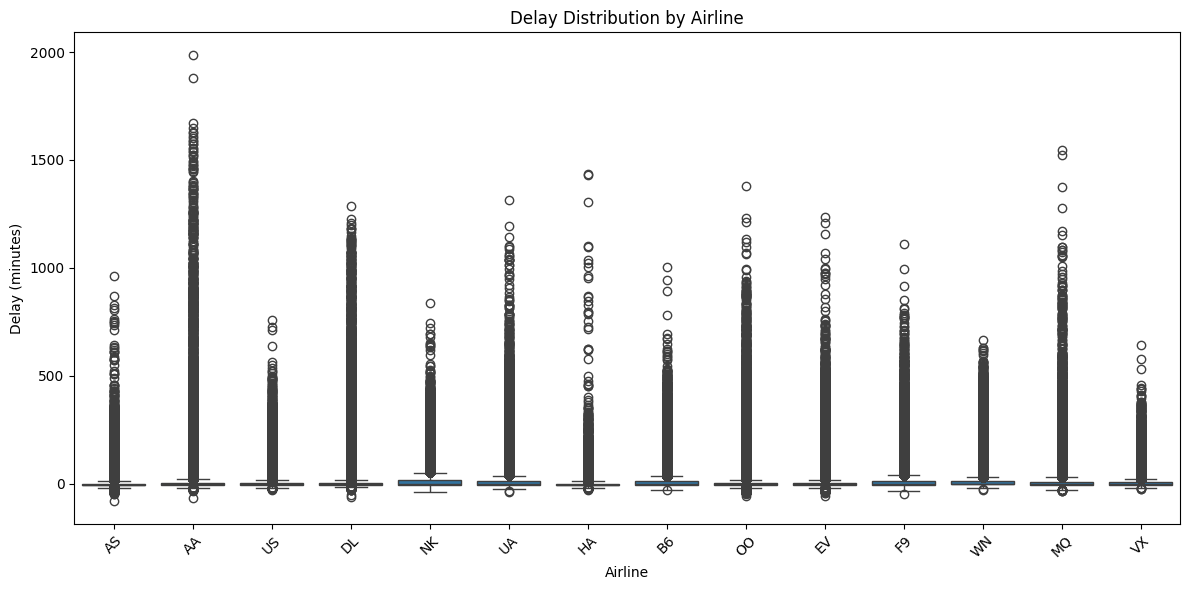

In [23]:
#garner delay by airline visual for EDA 
plt.figure(figsize=(12, 6))
sns.boxplot(x='AIRLINE', y='DEPARTURE_DELAY', data=airlinedata)
plt.xticks(rotation=45)
plt.title('Delay Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Delay (minutes)')
plt.tight_layout()
plt.show()

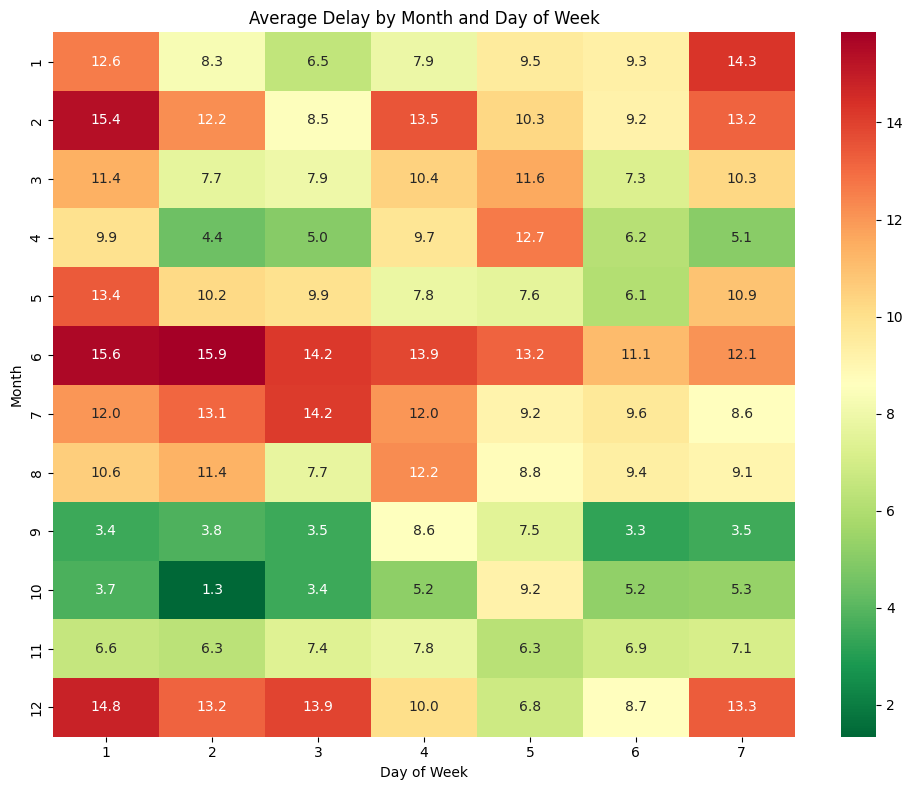

In [25]:
#pivot visualization for month/day delay averages 
pivot_table = airlinedata.pivot_table(values='DEPARTURE_DELAY', index='MONTH', columns='DAY_OF_WEEK', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn_r', fmt='.1f')
plt.title('Average Delay by Month and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

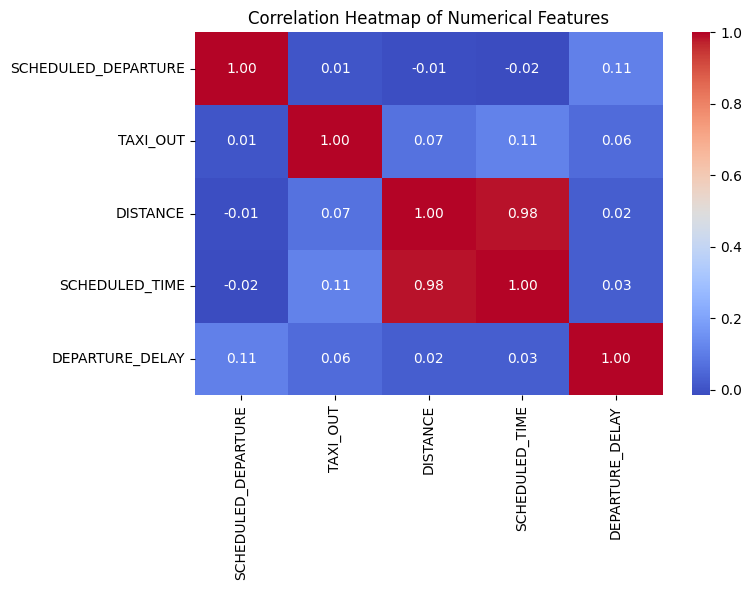

In [26]:
#check numerical cols for correlation 
numerical_cols = ['SCHEDULED_DEPARTURE', 'TAXI_OUT', 'DISTANCE', 'SCHEDULED_TIME', 'DEPARTURE_DELAY']
corr_matrix = airlinedata[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

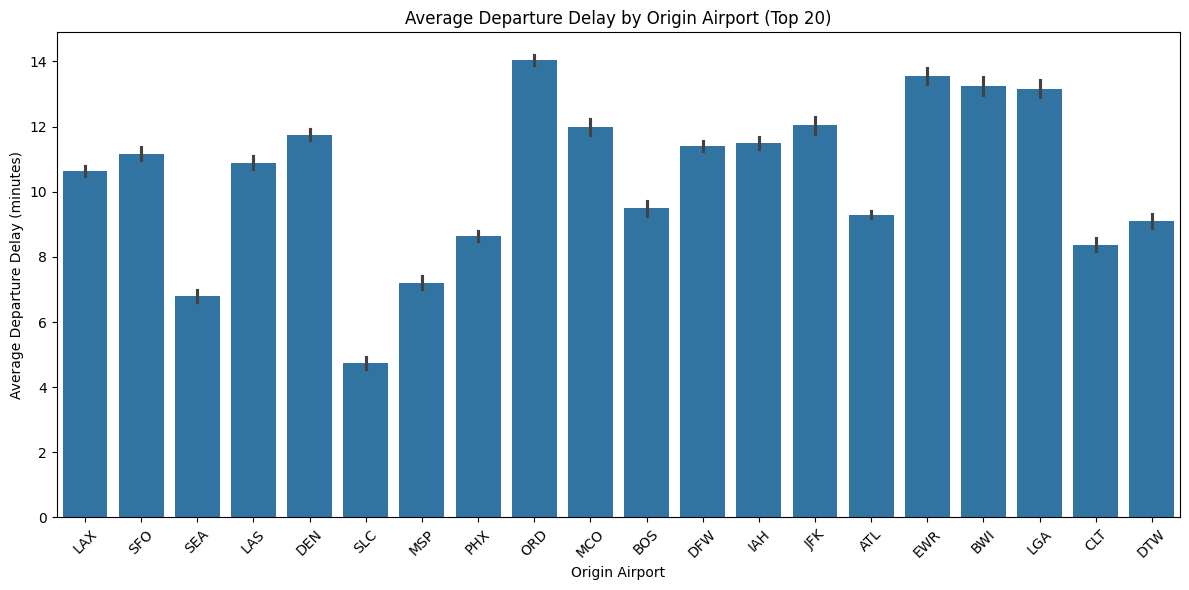

In [28]:
#inspect most frequent airports for potential outliers
top_airports = airlinedata['ORIGIN_AIRPORT'].value_counts().index[:20]
plt.figure(figsize=(12, 6))
sns.barplot(x='ORIGIN_AIRPORT', y='DEPARTURE_DELAY', data=airlinedata[airlinedata['ORIGIN_AIRPORT'].isin(top_airports)])
plt.xticks(rotation=45)
plt.title('Average Departure Delay by Origin Airport (Top 20)')
plt.xlabel('Origin Airport')
plt.ylabel('Average Departure Delay (minutes)')
plt.tight_layout()
plt.show()

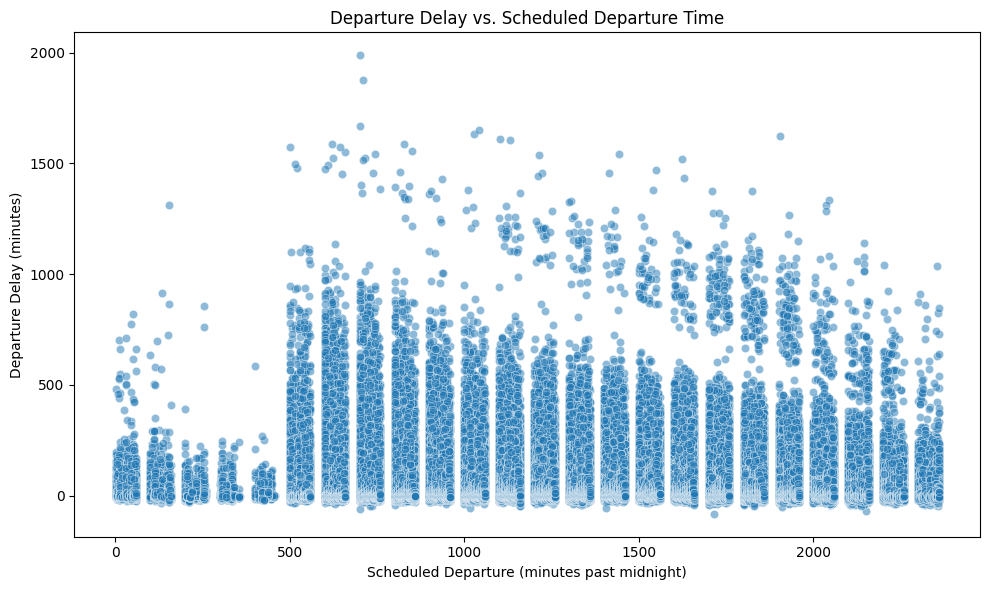

In [29]:
#visual for delay by scheduled time of day 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SCHEDULED_DEPARTURE', y='DEPARTURE_DELAY', data=airlinedata, alpha=0.5)
plt.title('Departure Delay vs. Scheduled Departure Time')
plt.xlabel('Scheduled Departure (minutes past midnight)')
plt.ylabel('Departure Delay (minutes)')
plt.tight_layout()
plt.show()

Correlation with DEPARTURE_DELAY:
DEPARTURE_DELAY        1.000000
SCHEDULED_DEPARTURE    0.110419
SCHEDULED_ARRIVAL      0.097689
TAXI_OUT               0.058423
SCHEDULED_TIME         0.027582
DISTANCE               0.023957
TAXI_IN                0.012479
DAY                   -0.000257
DAY_OF_WEEK           -0.011450
MONTH                 -0.021827
YEAR                        NaN
Name: DEPARTURE_DELAY, dtype: float64


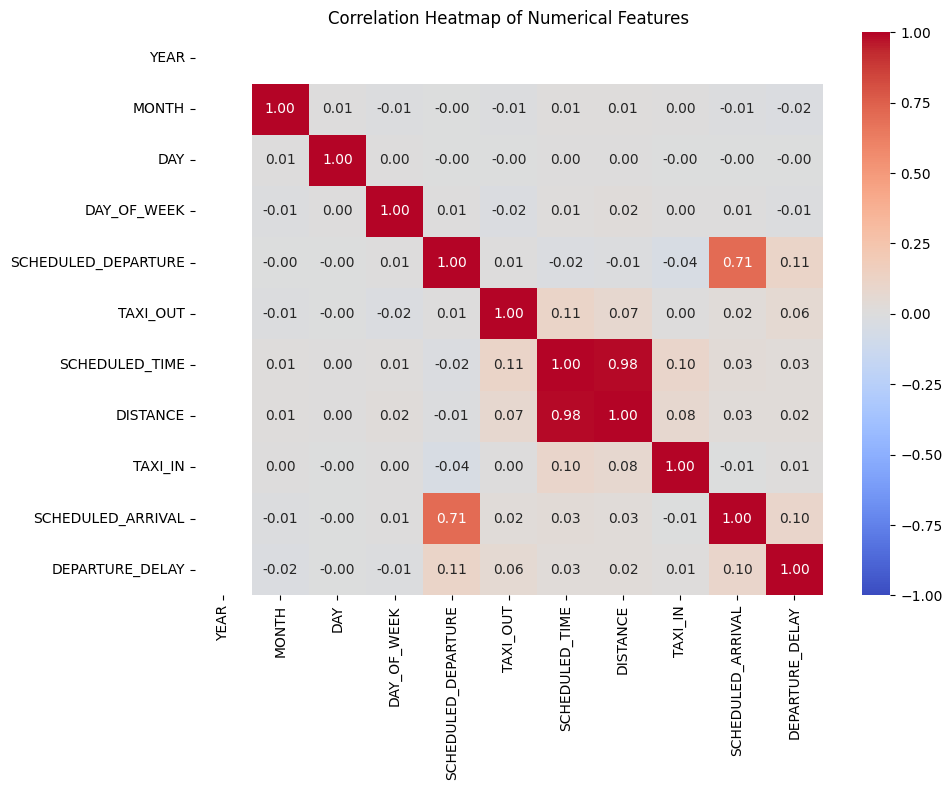

In [31]:
#evaluate numerical columns for correlation with delays 
nums = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'TAXI_OUT', 
                 'SCHEDULED_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'DEPARTURE_DELAY']
corrmat = airlinedata[nums].corr()
correlations = corrmat['DEPARTURE_DELAY'].sort_values(ascending=False)
print("Correlation with DEPARTURE_DELAY:")
print(correlations)
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [39]:
#create random forest for feature importance evaluation 
forestairlines = airlinedata.dropna(subset=['DEPARTURE_DELAY'])
cats = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TAIL_NUMBER']
for col in cats:
    le = LabelEncoder()
    forestairlines[col] = le.fit_transform(forestairlines[col].astype(str))
vars = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
            'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE']
xvars = forestairlines[vars]
yvars = forestairlines['DEPARTURE_DELAY']
redwoodforest = RandomForestRegressor(n_estimators=100, random_state=42)
redwoodforest.fit(xvars, yvars)
whatsimportant = pd.Series(redwoodforest.feature_importances_, index=vars).sort_values(ascending=False)
print("Feature Importances:")
print(whatsimportant)

KeyboardInterrupt: 